# Solve frozen lake with Q-network

> By Jonas Busk ([jbusk@dtu.dk](mailto:jbusk@dtu.dk))

Now we will solve the [FrozenLake](https://gym.openai.com/envs/FrozenLake-v0/) environment using on-policy neural Q-learning with epsilon-greedy action selection.

In the FrozenLake problem the reinforcement learning agent must navigate a small grid world by moving up, down, left and right. 
The task is to move from start position (S) to the goal (G) whithout falling into a hole (H). 
The task is made more difficult by the wind that will sometimes send the agent in a random direction regardless of the chosen action.
See an example start state below.

## Q-network

The method we will be using employs a Q-function which can be updated using bootstrapping:

$$
Q(s,a;\theta) \leftarrow Q(s,a;\theta) + \alpha \delta \ ,
$$

where $\delta = r + \gamma \max_{a'} Q(s',a';\theta) - Q(s,a;\theta)$ is the TD error.

Since we use a neural network to represent $Q$, we cannot do this assignment directly, but instead perform a gradient update using squared loss: 

$$
L(\theta) = \delta^2 \ ,
$$

with transitions $(s,a,r,s')$ sampled from the environment. 

Algorithm:

1. Do a forward pass for current state, $s$, to get predicted Q-values for all actions.
2. Select an action, $a$, with epsilon-greedy strategy and execute it to observe a reward and next state, $r,s'$.
3. Do a forward pass for the next state, $s'$.
4. Set Q-target for action $a$ to $r + \gamma \max_{a'} Q(s',a';\theta)$ and to the Q-values from step 1 for all other actions, making the TD error zero for those outputs.
5. Update network weights with backpropagation.
6. Set $s\leftarrow s'$ and repeat.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym

First we initialize the FrozenLake environment and display an example of the state.

In [2]:
env = gym.make('FrozenLake-v0')

In [3]:
# show init state
s = env.reset()
env.render()


SFFF
FHFH
FFFH
HFFG


## Network and functions

Next let's implement the Q-network class.

In [12]:
class QNetwork(nn.Module):
    """Q-network"""

    def __init__(self, n_inputs, n_outputs, learning_rate):
        super(QNetwork, self).__init__()
        # network
        self.out = nn.Linear(n_inputs, n_outputs, bias=False)
        torch.nn.init.uniform_(self.out.weight, 0, 0.01)
        # training
        self.optimizer = optim.SGD(self.parameters(), lr=learning_rate)

    def forward(self, x):
        return self.out(x)
    
    def loss(self, q_outputs, q_targets):
        return torch.sum(torch.pow(q_targets - q_outputs, 2))

In [13]:
def one_hot(i, l):
    """One-hot encoder for the states"""
    a = np.zeros((len(i), l))
    a[range(len(i)), i] = 1
    return a

In [57]:
def train(num_episodes, episode_limit, learning_rate, gamma, val_freq, epsilon_start, qnet):
    try:
        epsilon = epsilon_start
        rewards, lengths, losses, epsilons = [], [], [], []
        print('start training')
        for i in range(num_episodes):
            # init new episode
            s, ep_reward, ep_loss = env.reset(), 0, 0
            for j in range(episode_limit):
                # 1. do foward pass of current state to compute Q-values for all actions
                qnet.optimizer.zero_grad()
                Q = qnet(torch.from_numpy(one_hot([s], n_inputs)).float())
                # 2. select action with epsilon-greedy strategy
                if np.random.rand() > epsilon:
                    a = Q.argmax().item()
                else: 
                    a = env.action_space.sample()
                s1, r, done, _ = env.step(a)
                # 3. do forward pass for the next state
                with torch.no_grad():
                    Q1 = qnet(torch.from_numpy(one_hot([s1], n_inputs)).float())
                # 4. set Q-target
                q_target = Q.clone()
                q_target[0, a] = r + gamma * Q1.max().item() * (not done)
                # 5. update network weights
                loss = qnet.loss(Q, q_target)
                loss.backward()
                qnet.optimizer.step()
                # 6. bookkeeping
                s = s1
                ep_reward += r
                ep_loss += loss.item()
                if done: break
            # bookkeeping
            epsilon *= num_episodes/(i/(num_episodes/20)+num_episodes) # decrease epsilon
            epsilons.append(epsilon); rewards.append(ep_reward); lengths.append(j+1); losses.append(ep_loss)
            if (i+1) % val_freq == 0: print('{:5d} mean training reward: {:5.2f}'.format(i+1, np.mean(rewards[-val_freq:])))
        print('done')
    except KeyboardInterrupt:
        print('interrupt')
        
    return rewards, lengths, losses, epsilons

In [53]:
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

## Default network
- Final reward: 0.70
- Mean reward: 0.335

In [67]:
# train Q-network
num_eps = 1000 # number of episodes
ep_lim = 100 # episode limit
lr = 0.1 # learning rate
dr = 0.99 # discount rate
vf = 100 # validation frequency
eps_start = 1.0

n_inputs = env.observation_space.n
n_outputs = env.action_space.n

net = QNetwork(n_inputs, n_outputs, lr)

rewards, lengths, losses, epsilons = train(num_eps, ep_lim, lr, dr, vf, eps_start, net)

print(f"\nMean training reward: {np.mean(rewards)}")

start training
  100 mean training reward:  0.01
  200 mean training reward:  0.01
  300 mean training reward:  0.03
  400 mean training reward:  0.05
  500 mean training reward:  0.14
  600 mean training reward:  0.36
  700 mean training reward:  0.58
  800 mean training reward:  0.77
  900 mean training reward:  0.70
 1000 mean training reward:  0.70
done

Mean training reward: 0.335


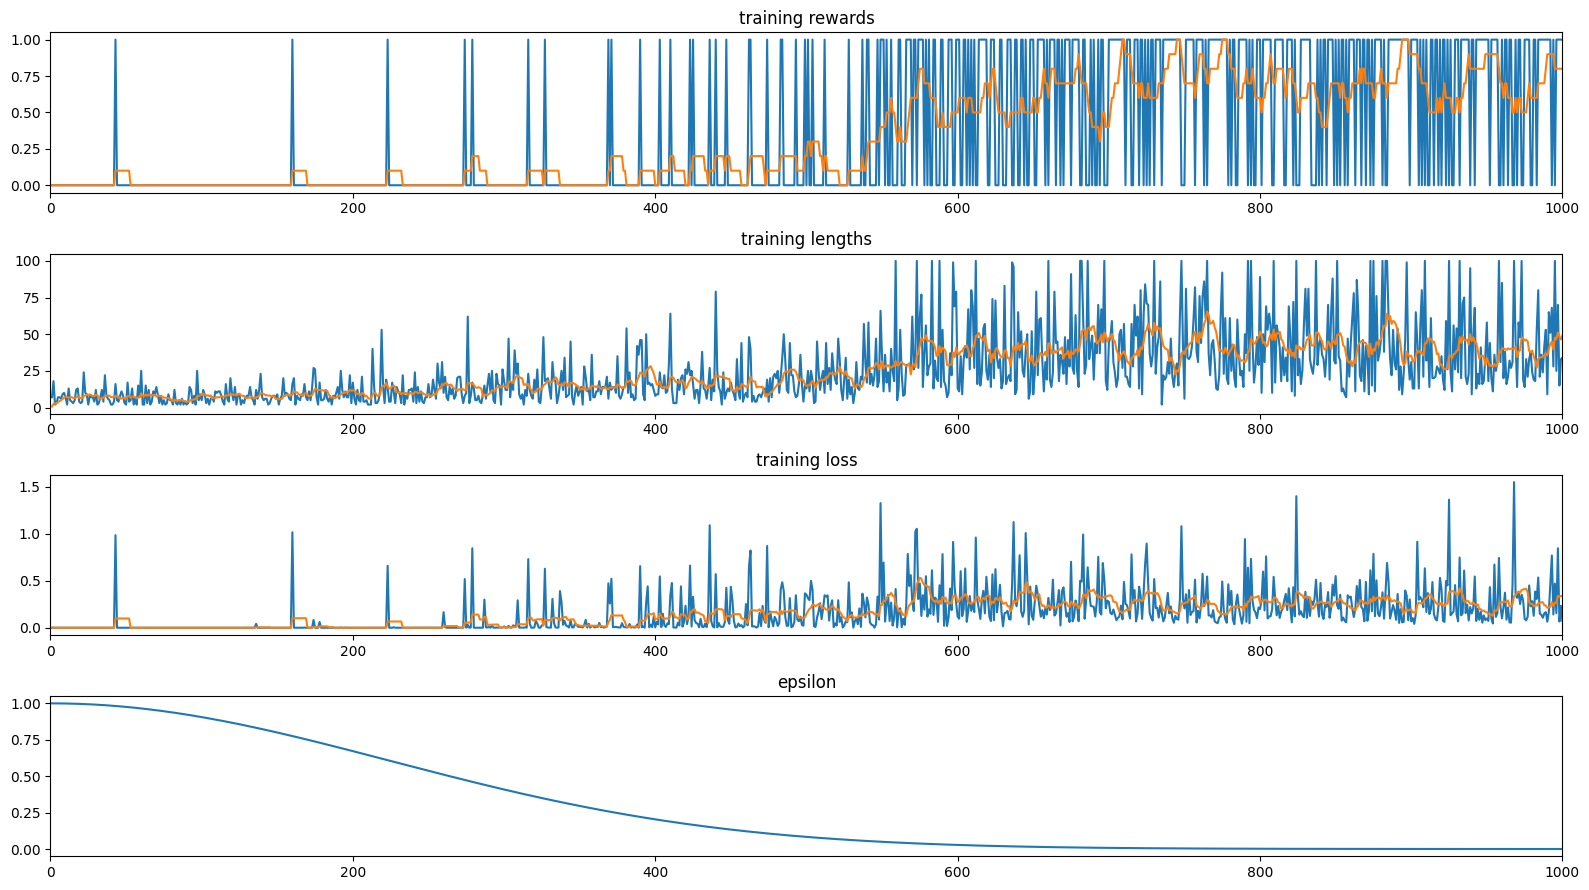

In [68]:
# plot results
plt.figure(figsize=(16, 9))

plt.subplot(411)
plt.title('training rewards')
plt.plot(range(1, num_episodes+1), rewards)
plt.plot(range(1, num_episodes+1), moving_average(rewards))
plt.xlim([0, num_episodes])

plt.subplot(412)
plt.title('training lengths')
plt.plot(range(1, num_episodes+1), lengths)
plt.plot(range(1, num_episodes+1), moving_average(lengths))
plt.xlim([0, num_episodes])

plt.subplot(413)
plt.title('training loss')
plt.plot(range(1, num_episodes+1), losses)
plt.plot(range(1, num_episodes+1), moving_average(losses))
plt.xlim([0, num_episodes])

plt.subplot(414)
plt.title('epsilon')
plt.plot(range(1, num_episodes+1), epsilons)
plt.xlim([0, num_episodes])

plt.tight_layout(); plt.show()

Now let's review the solution! You can run the cell multiple times to see the behavior of the Q-network.

In [10]:
s = env.reset()
env.render()
for _ in range(100):
    a = net(torch.from_numpy(one_hot([s], n_inputs)).float()).argmax().item()
    s, r, done, _ = env.step(a)
    env.render()
    if done: break


SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG


## Exercises

Read and understand the code, then play around with it and try to make it learn better and faster.

Experiment with the:

* number of episodes
* discount factor
* learning rate
* network layers

### Exercise 1 

*Describe any changes you made to the code and why you think they improve the agent.*

**Answer:**

*Answer here...*

#### Number of episodes 
10000
- Final reward: 0.63
- Mean reward: 0.3678

3000
- Final reward: 0.72
- Mean reward: 0.369

In [108]:
# train Q-network
num_eps = 3000 # number of episodes
ep_lim = 100 # episode limit
lr = 0.1 # learning rate
dr = 0.99 # discount rate
vf = 100 # validation frequency
eps_start = 1.0

n_inputs = env.observation_space.n
n_outputs = env.action_space.n

net = QNetwork(n_inputs, n_outputs, lr)

rewards, lengths, losses, epsilons = train(num_eps, ep_lim, lr, dr, vf, eps_start, net)

print(f"\nMean training reward: {np.mean(rewards)}")

start training
  100 mean training reward:  0.03
  200 mean training reward:  0.03
  300 mean training reward:  0.03
  400 mean training reward:  0.00
  500 mean training reward:  0.02
  600 mean training reward:  0.03
  700 mean training reward:  0.04
  800 mean training reward:  0.08
  900 mean training reward:  0.08
 1000 mean training reward:  0.17
 1100 mean training reward:  0.16
 1200 mean training reward:  0.17
 1300 mean training reward:  0.17
 1400 mean training reward:  0.22
 1500 mean training reward:  0.37
 1600 mean training reward:  0.37
 1700 mean training reward:  0.58
 1800 mean training reward:  0.43
 1900 mean training reward:  0.40
 2000 mean training reward:  0.66
 2100 mean training reward:  0.71
 2200 mean training reward:  0.72
 2300 mean training reward:  0.70
 2400 mean training reward:  0.79
 2500 mean training reward:  0.61
 2600 mean training reward:  0.65
 2700 mean training reward:  0.66
 2800 mean training reward:  0.71
 2900 mean training reward:  0.76

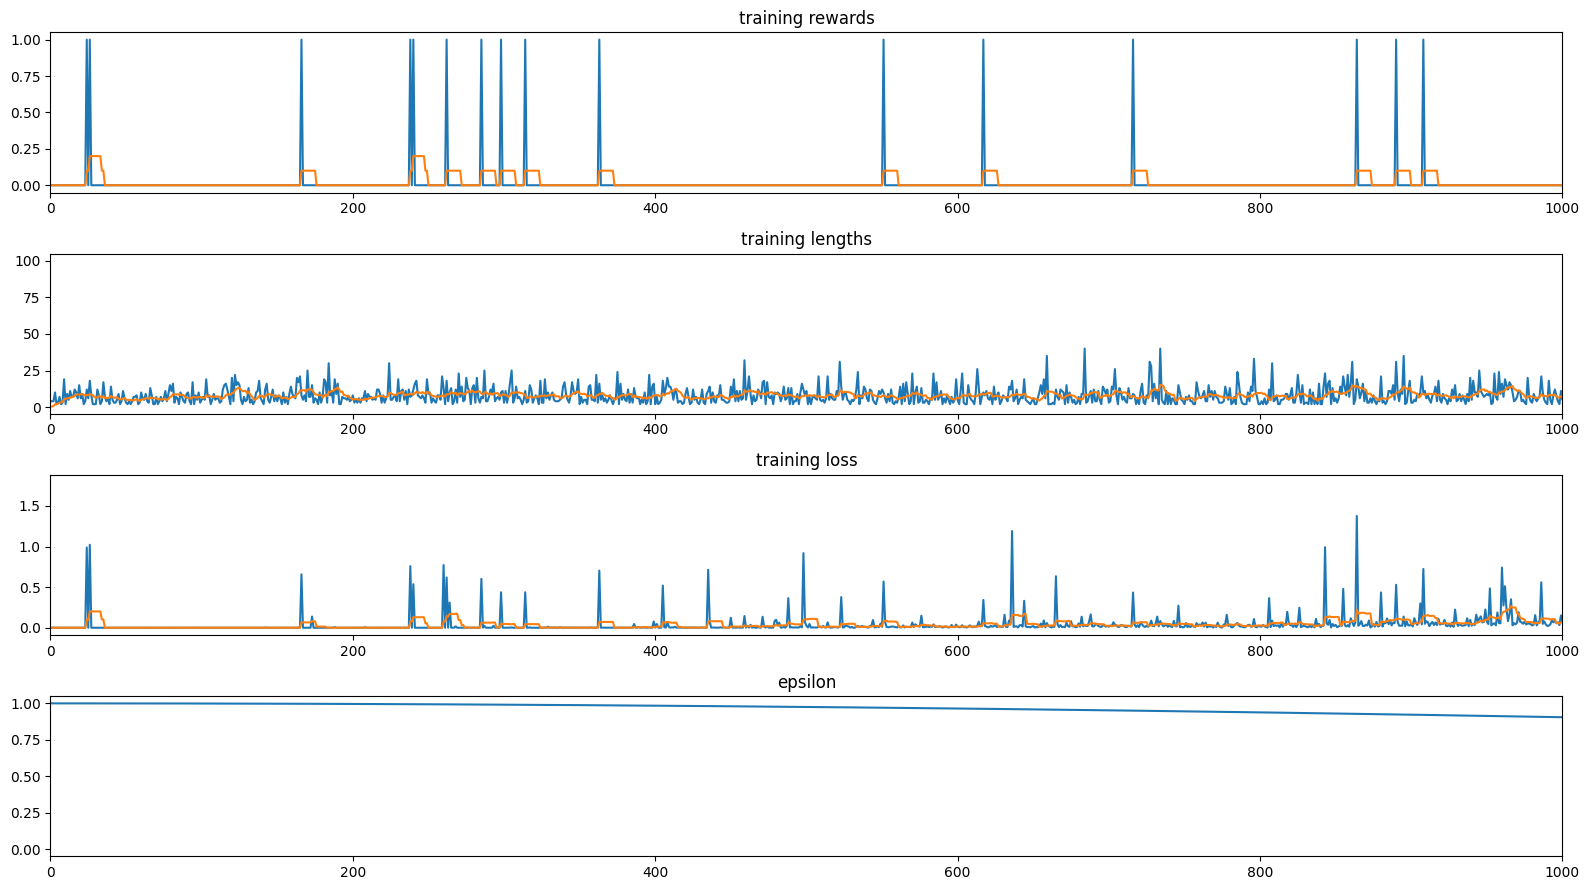

In [71]:
# plot results
plt.figure(figsize=(16, 9))

plt.subplot(411)
plt.title('training rewards')
plt.plot(range(1, num_eps+1), rewards)
plt.plot(range(1, num_eps+1), moving_average(rewards))
plt.xlim([0, num_episodes])

plt.subplot(412)
plt.title('training lengths')
plt.plot(range(1, num_eps+1), lengths)
plt.plot(range(1, num_eps+1), moving_average(lengths))
plt.xlim([0, num_episodes])

plt.subplot(413)
plt.title('training loss')
plt.plot(range(1, num_eps+1), losses)
plt.plot(range(1, num_eps+1), moving_average(losses))
plt.xlim([0, num_episodes])

plt.subplot(414)
plt.title('epsilon')
plt.plot(range(1, num_eps+1), epsilons)
plt.xlim([0, num_episodes])

plt.tight_layout(); plt.show()

#### Learning Rate (num_episodes = 3000)
0.5
- Final reward: 0.0
- Mean reward: 0.01

0.1
- Final reward: 0.68
- Mean reward: 0.36

0.01
- Final reward: 0.28
- Mean reward: 0.174

0.001
- Final reward: 0.22
- Mean reward: 0.07

In [76]:
# train Q-network
num_eps = 3000 # number of episodes
ep_lim = 100 # episode limit
lr = 0.1 # learning rate
dr = 0.99 # discount rate
vf = 100 # validation frequency
eps_start = 1.0

n_inputs = env.observation_space.n
n_outputs = env.action_space.n

net = QNetwork(n_inputs, n_outputs, lr)

rewards, lengths, losses, epsilons = train(num_eps, ep_lim, lr, dr, vf, eps_start, net)

print(f"\nMean training reward: {np.mean(rewards)}")

start training
  100 mean training reward:  0.02
  200 mean training reward:  0.02
  300 mean training reward:  0.02
  400 mean training reward:  0.03
  500 mean training reward:  0.01
  600 mean training reward:  0.02
  700 mean training reward:  0.03
  800 mean training reward:  0.02
  900 mean training reward:  0.05
 1000 mean training reward:  0.07
 1100 mean training reward:  0.16
 1200 mean training reward:  0.18
 1300 mean training reward:  0.20
 1400 mean training reward:  0.31
 1500 mean training reward:  0.30
 1600 mean training reward:  0.42
 1700 mean training reward:  0.56
 1800 mean training reward:  0.56
 1900 mean training reward:  0.43
 2000 mean training reward:  0.45
 2100 mean training reward:  0.64
 2200 mean training reward:  0.64
 2300 mean training reward:  0.68
 2400 mean training reward:  0.73
 2500 mean training reward:  0.70
 2600 mean training reward:  0.79
 2700 mean training reward:  0.68
 2800 mean training reward:  0.68
 2900 mean training reward:  0.71

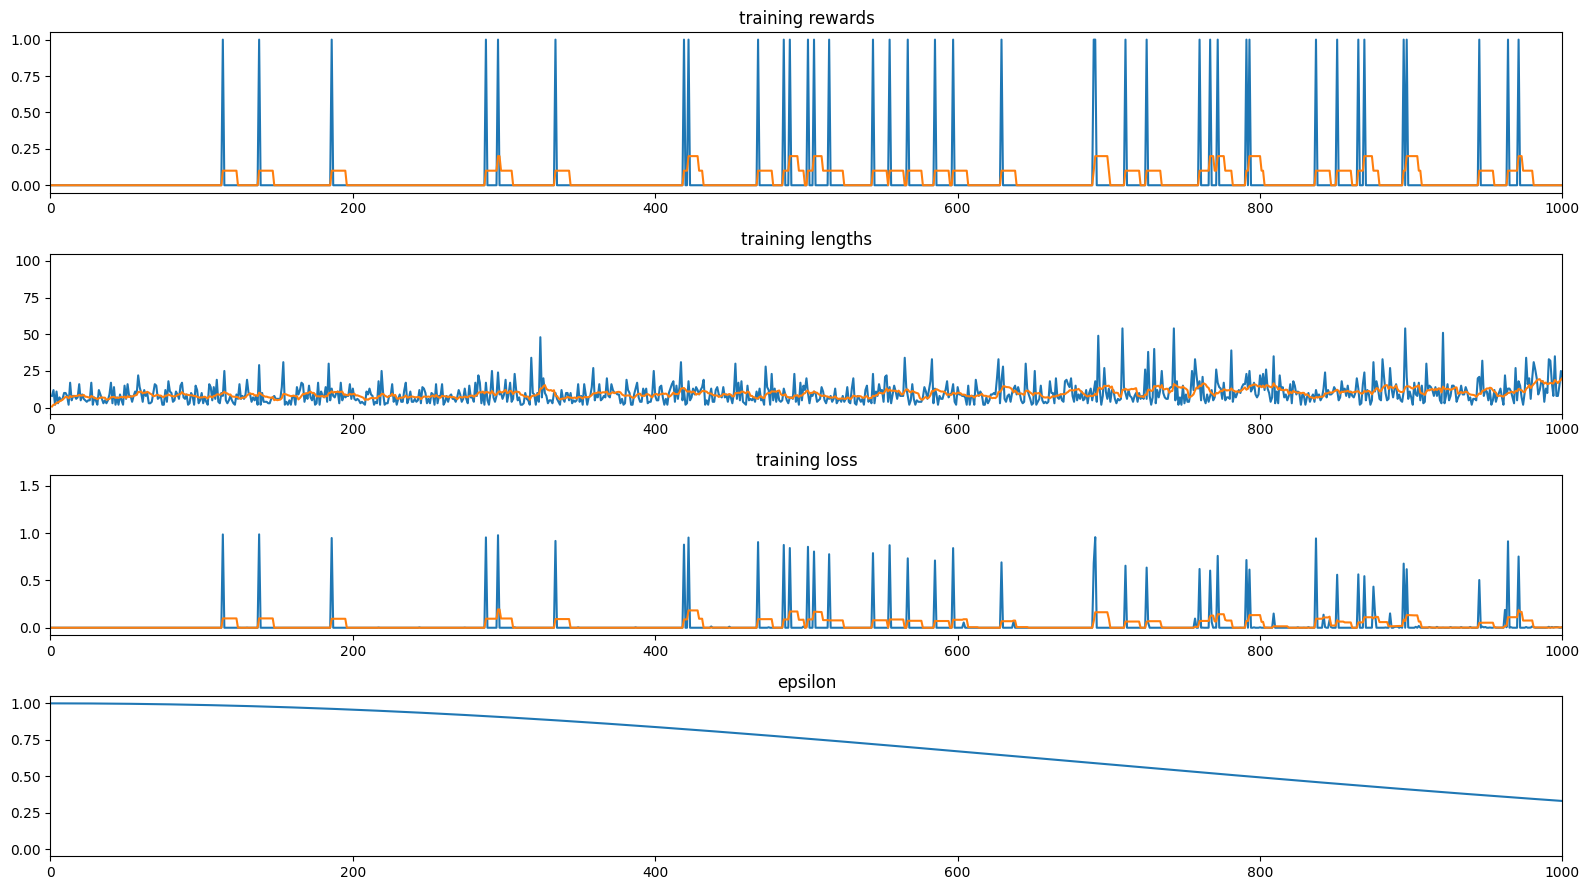

In [73]:
# plot results
plt.figure(figsize=(16, 9))

plt.subplot(411)
plt.title('training rewards')
plt.plot(range(1, num_eps+1), rewards)
plt.plot(range(1, num_eps+1), moving_average(rewards))
plt.xlim([0, num_episodes])

plt.subplot(412)
plt.title('training lengths')
plt.plot(range(1, num_eps+1), lengths)
plt.plot(range(1, num_eps+1), moving_average(lengths))
plt.xlim([0, num_episodes])

plt.subplot(413)
plt.title('training loss')
plt.plot(range(1, num_eps+1), losses)
plt.plot(range(1, num_eps+1), moving_average(losses))
plt.xlim([0, num_episodes])

plt.subplot(414)
plt.title('epsilon')
plt.plot(range(1, num_eps+1), epsilons)
plt.xlim([0, num_episodes])

plt.tight_layout(); plt.show()

### Discount Rate
1
- Final reward: 0.63
- Mean reward: 0.34

0.99
- Final reward: 0.67
- Mean reward: 0.364

0.95
- Final reward: 0.6
- Mean reward: 0.335

0.9
- Final reward: 0.39
- Mean reward: 0.24

In [79]:
# train Q-network
num_eps = 3000 # number of episodes
ep_lim = 100 # episode limit
lr = 0.1 # learning rate
dr = 0.9 # discount rate
vf = 100 # validation frequency
eps_start = 1.0

n_inputs = env.observation_space.n
n_outputs = env.action_space.n

net = QNetwork(n_inputs, n_outputs, lr)

rewards, lengths, losses, epsilons = train(num_eps, ep_lim, lr, dr, vf, eps_start, net)

print(f"\nMean training reward: {np.mean(rewards)}")

start training
  100 mean training reward:  0.02
  200 mean training reward:  0.03
  300 mean training reward:  0.00
  400 mean training reward:  0.01
  500 mean training reward:  0.05
  600 mean training reward:  0.05
  700 mean training reward:  0.03
  800 mean training reward:  0.06
  900 mean training reward:  0.11
 1000 mean training reward:  0.03
 1100 mean training reward:  0.07
 1200 mean training reward:  0.14
 1300 mean training reward:  0.13
 1400 mean training reward:  0.25
 1500 mean training reward:  0.25
 1600 mean training reward:  0.32
 1700 mean training reward:  0.45
 1800 mean training reward:  0.35
 1900 mean training reward:  0.42
 2000 mean training reward:  0.60
 2100 mean training reward:  0.32
 2200 mean training reward:  0.51
 2300 mean training reward:  0.43
 2400 mean training reward:  0.33
 2500 mean training reward:  0.33
 2600 mean training reward:  0.44
 2700 mean training reward:  0.41
 2800 mean training reward:  0.43
 2900 mean training reward:  0.49

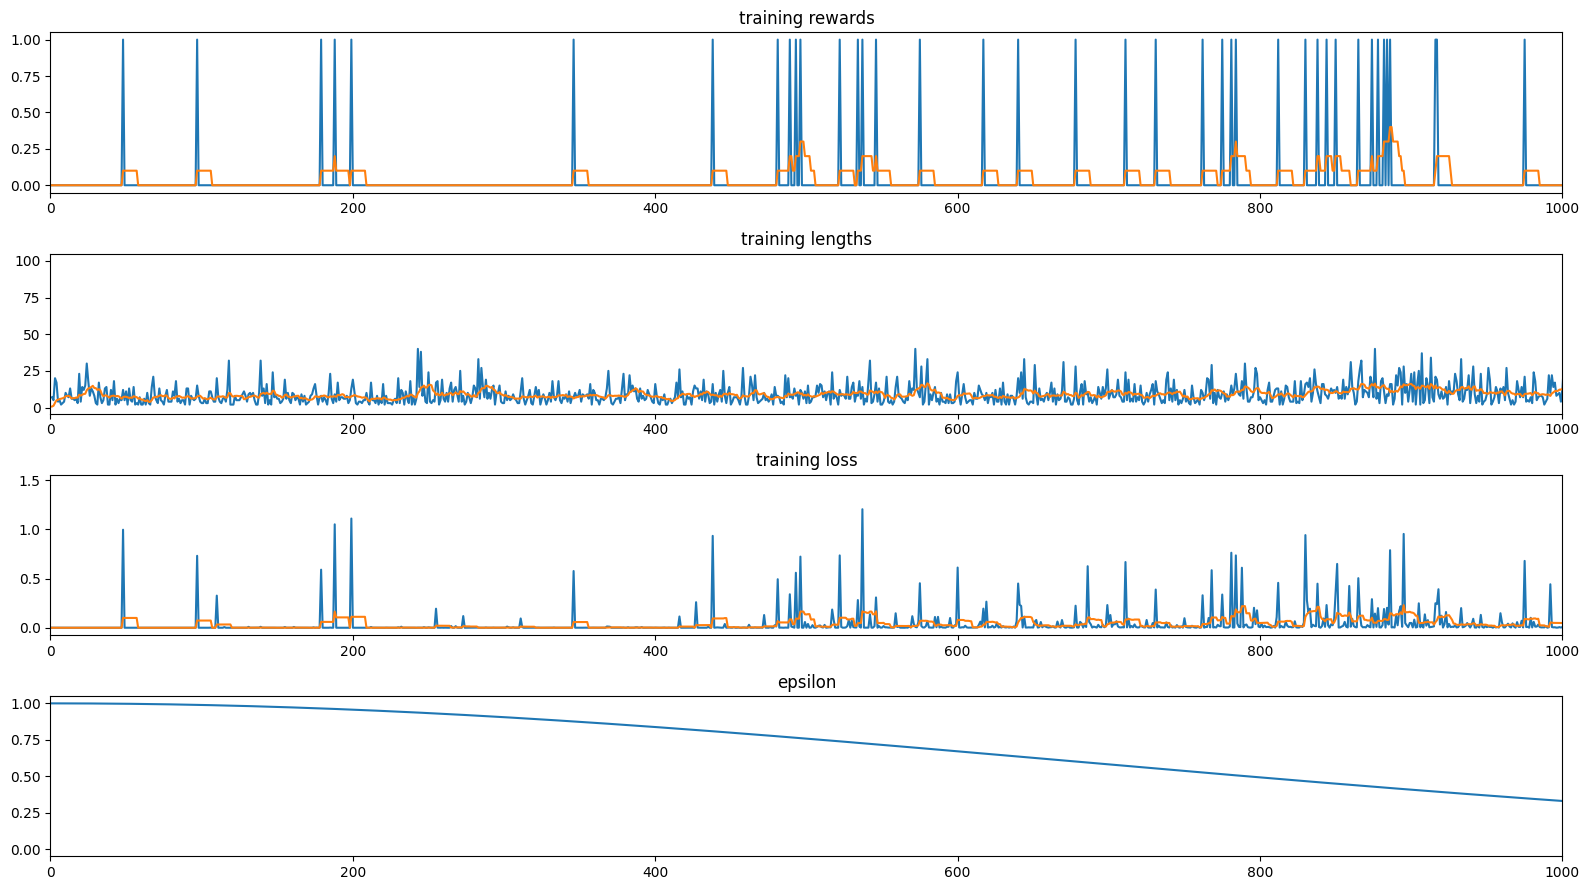

In [80]:
# plot results
plt.figure(figsize=(16, 9))

plt.subplot(411)
plt.title('training rewards')
plt.plot(range(1, num_eps+1), rewards)
plt.plot(range(1, num_eps+1), moving_average(rewards))
plt.xlim([0, num_episodes])

plt.subplot(412)
plt.title('training lengths')
plt.plot(range(1, num_eps+1), lengths)
plt.plot(range(1, num_eps+1), moving_average(lengths))
plt.xlim([0, num_episodes])

plt.subplot(413)
plt.title('training loss')
plt.plot(range(1, num_eps+1), losses)
plt.plot(range(1, num_eps+1), moving_average(losses))
plt.xlim([0, num_episodes])

plt.subplot(414)
plt.title('epsilon')
plt.plot(range(1, num_eps+1), epsilons)
plt.xlim([0, num_episodes])

plt.tight_layout(); plt.show()

### Network Layers

- Making the network deeper only seems to decrease the training reward.

In [109]:
class CustomLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        torch.nn.init.uniform_(self.linear.weight, 0, 0.01)
        
    def forward(self, x):
        return self.linear(x)

In [123]:
class QNetwork2(nn.Module):
    """Q-network"""

    def __init__(self, n_inputs, n_outputs, learning_rate):
        super(QNetwork2, self).__init__()
        # network
        self.hidden = nn.Sequential(
            CustomLinear(n_inputs, 164, bias=True),
            nn.ReLU(),
            nn.Dropout(0.5), 
            CustomLinear(164, n_outputs, bias=True)
        )
        
        # training
        self.optimizer = optim.SGD(self.parameters(), lr=learning_rate)

    def forward(self, x):
        return self.hidden(x)
    
    def loss(self, q_outputs, q_targets):
        return torch.sum(torch.pow(q_targets - q_outputs, 2))

In [124]:
# train Q-network
num_eps = 3000 # number of episodes
ep_lim = 100 # episode limit
lr = 0.1 # learning rate
dr = 0.99 # discount rate
vf = 100 # validation frequency
eps_start = 1.0

n_inputs = env.observation_space.n # 16
n_outputs = env.action_space.n # 4

# net = QNetwork(n_inputs, n_outputs, lr)
net = QNetwork2(n_inputs, n_outputs, lr)

rewards, lengths, losses, epsilons = train(num_eps, ep_lim, lr, dr, vf, eps_start, net)

print(f"\nMean training reward: {np.mean(rewards)}")

start training
  100 mean training reward:  0.00
  200 mean training reward:  0.02
  300 mean training reward:  0.01
  400 mean training reward:  0.01
  500 mean training reward:  0.03
  600 mean training reward:  0.01
  700 mean training reward:  0.02
  800 mean training reward:  0.01
  900 mean training reward:  0.05
 1000 mean training reward:  0.01
 1100 mean training reward:  0.03
 1200 mean training reward:  0.05
 1300 mean training reward:  0.05
 1400 mean training reward:  0.04
 1500 mean training reward:  0.09
 1600 mean training reward:  0.06
 1700 mean training reward:  0.09
 1800 mean training reward:  0.04
 1900 mean training reward:  0.07
 2000 mean training reward:  0.07
 2100 mean training reward:  0.09
 2200 mean training reward:  0.12
 2300 mean training reward:  0.04
 2400 mean training reward:  0.08
 2500 mean training reward:  0.07
 2600 mean training reward:  0.03
 2700 mean training reward:  0.08
 2800 mean training reward:  0.01
 2900 mean training reward:  0.05

### Exercise 2

*How high mean training a reward is your solution able to achieve? Do you think it is possible to go even higher? Why/why not?*

**Answer:**

The highest reward I achieved was 0.76.
It might be possible to achieve better results using deep reinforcement learning (DRL), or policy gradient methods, or completely different Q-network architectures.

It is worth clarifying the reward 1 is given only in the goal state, so it is impossible within the context of the "FrozenLake-v0" game to have a mean reward of 1, as the agent will have to take multiple steps before reaching the goal state.

It is also important to note that the reward value is only one aspect of the performance of a reinforcement learning agent, and that other factors, such as the number of steps taken to reach the goal or the number of episodes needed to converge to the optimal policy, may also be important. A high reward value does not necessarily indicate a successful or optimal solution, and a low reward value does not necessarily indicate a poor solution. The best way to evaluate the performance of a reinforcement learning agent is to consider multiple metrics and to analyze the agent's behavior in the context of the specific task and environment. Some of these other metrics could be:
- Episode reward: The average reward received by the agent over a fixed number of episodes. This metric measures how well the agent is doing with respect to the reward function.
- Episode length: The average number of steps taken by the agent to reach the end of an episode. This metric measures the efficiency of the agent's policy.
- Convergence speed: The rate at which the agent's performance improves over time, measured by the change in the average episode reward or episode length over a certain number of episodes.
- Optimal policy: The percentage of episodes in which the agent reaches the goal state, or the state that corresponds to the maximum reward.
- Exploratory behavior: The balance between exploration and exploitation in the agent's policy, measured by the number of unique states visited, the number of unique actions taken, or the entropy of the policy distribution.

### Exercise 3

*What role does epsilon play in the code above? Try and change the epsilon start value or the line of code that decreases eplison every update step. How does it affect learning?*

**Answer:**

Epsilon (𝜖) is a parameter in epsilon-greedy action selection that determines the probability of randomly choosing an action rather than relying on the highest estimated Q-value. In other words, epsilon is a measure of how much exploration an agent will perform in the decision-making process. The lower the value of epsilon, the more the agent relies on the estimated Q-values and the less it explores.

Epsilon decreases as training progresses becauses we want the agent to trust the already trained Q-network.

Epsilon:
- 0.01: final reward - 0.41
- 0.1: final reward - 0.72
- 0.5: final reward - 0.73
- 1: final reward - 0.76

In [120]:
# train Q-network
num_eps = 3000 # number of episodes
ep_lim = 100 # episode limit
lr = 0.1 # learning rate
dr = 0.99 # discount rate
vf = 100 # validation frequency
eps_start = 1

n_inputs = env.observation_space.n
n_outputs = env.action_space.n

net = QNetwork(n_inputs, n_outputs, lr)

rewards, lengths, losses, epsilons = train(num_eps, ep_lim, lr, dr, vf, eps_start, net)

print(f"\nMean training reward: {np.mean(rewards)}")

start training
  100 mean training reward:  0.00
  200 mean training reward:  0.00
  300 mean training reward:  0.02
  400 mean training reward:  0.02
  500 mean training reward:  0.02
  600 mean training reward:  0.01
  700 mean training reward:  0.04
  800 mean training reward:  0.05
  900 mean training reward:  0.09
 1000 mean training reward:  0.06
 1100 mean training reward:  0.15
 1200 mean training reward:  0.17
 1300 mean training reward:  0.28
 1400 mean training reward:  0.33
 1500 mean training reward:  0.32
 1600 mean training reward:  0.46
 1700 mean training reward:  0.48
 1800 mean training reward:  0.48
 1900 mean training reward:  0.43
 2000 mean training reward:  0.69
 2100 mean training reward:  0.52
 2200 mean training reward:  0.63
 2300 mean training reward:  0.71
 2400 mean training reward:  0.62
 2500 mean training reward:  0.79
 2600 mean training reward:  0.73
 2700 mean training reward:  0.90
 2800 mean training reward:  0.72
 2900 mean training reward:  0.75

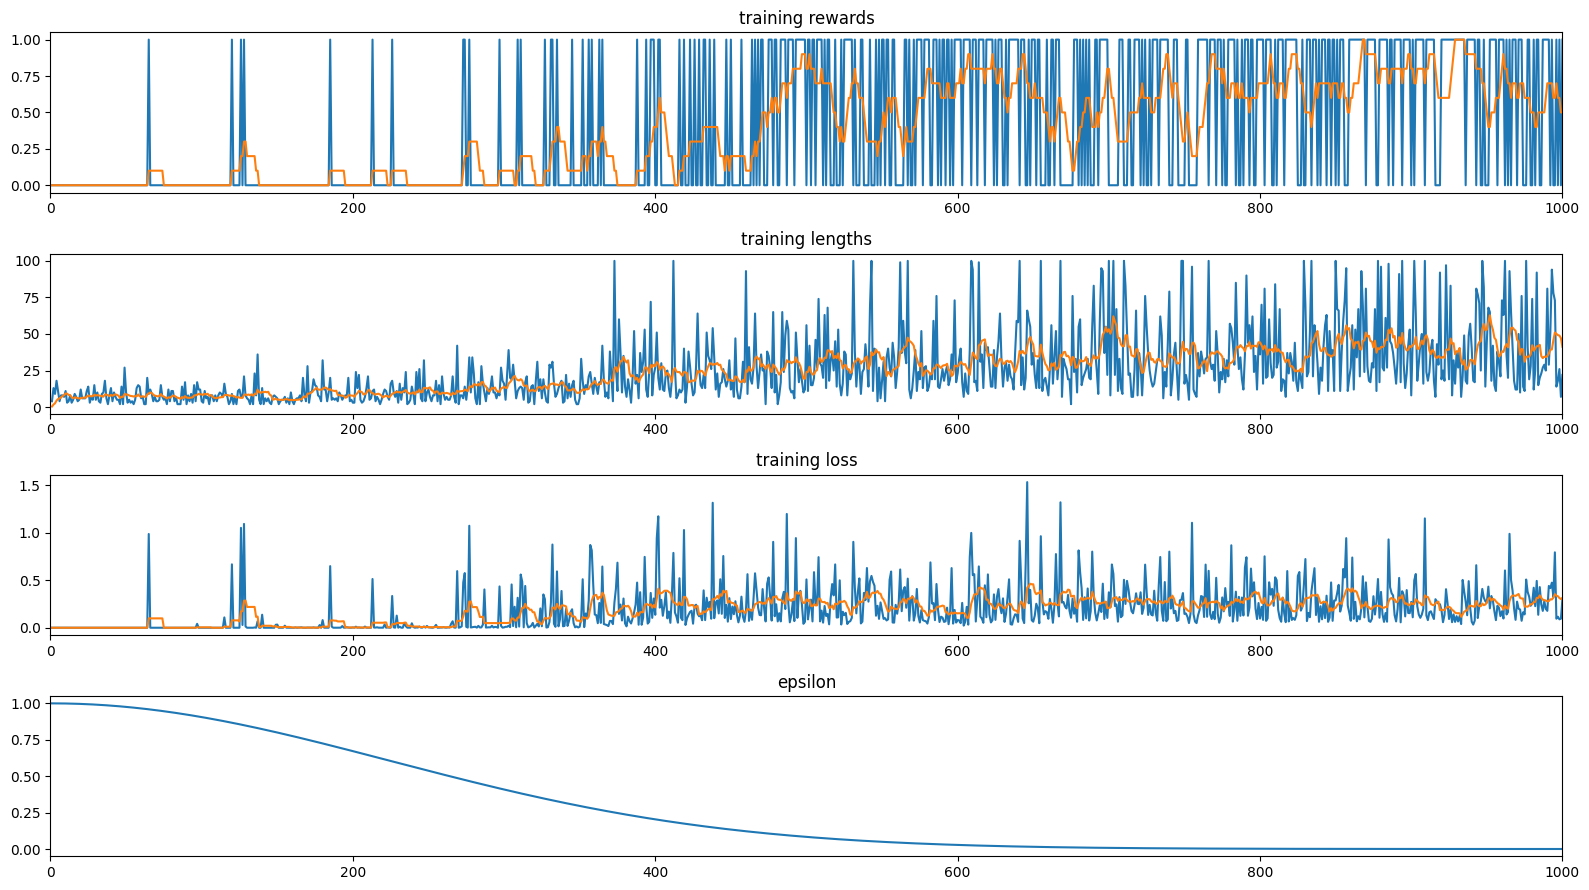

In [50]:
# plot results
plt.figure(figsize=(16, 9))

plt.subplot(411)
plt.title('training rewards')
plt.plot(range(1, num_eps+1), rewards)
plt.plot(range(1, num_eps+1), moving_average(rewards))
plt.xlim([0, num_episodes])

plt.subplot(412)
plt.title('training lengths')
plt.plot(range(1, num_eps+1), lengths)
plt.plot(range(1, num_eps+1), moving_average(lengths))
plt.xlim([0, num_episodes])

plt.subplot(413)
plt.title('training loss')
plt.plot(range(1, num_eps+1), losses)
plt.plot(range(1, num_eps+1), moving_average(losses))
plt.xlim([0, num_episodes])

plt.subplot(414)
plt.title('epsilon')
plt.plot(range(1, num_eps+1), epsilons)
plt.xlim([0, num_episodes])

plt.tight_layout(); plt.show()

In [34]:
s = env.reset()
env.render()
num_steps = 0
for _ in range(100):
    a = net(torch.from_numpy(one_hot([s], n_inputs)).float()).argmax().item()
    s, r, done, _ = env.step(a)
    num_steps += 1
    env.render()
    if done: 
        print(f"# of steps: {num_steps}")
        break


SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HF